In [3]:
# import PseudoNetCDF as pnc
import os
import glob
from subprocess import check_output
import xarray as xr
import utils
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from CSET_data_classes import CSET_Flight_Piece, CSET_Flight
from scipy.interpolate import interp1d
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import glob
from subprocess import check_output

files = glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/chemistry/ict/*.ict')
for f in files:
    ofile = f[:-4]+'.nc'
    pnc_call = "python -m PseudoNetCDF.pncgen -f ffi1001 {} {}".format(f, ofile)
#     check_output(pnc_call, shell=True, cwd = '/home/disk/p/jkcm')

In [3]:
# for f in files:
#     date = f[-14:-6]
#     flight = utils.datemap[date]
#     newfile = f[:-5]+flight+'.nc'
#     cp_call = "cp {} {}".format(f, newfile)
# #     check_output(cp_call, shell=True, cwd = '/home/disk/p/jkcm')
# #     print(cp_call)

In [55]:
files = glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/chemistry/*.nc')

In [24]:
sorted(files)[10]

'/home/disk/eos4/jkcm/Data/CSET/chemistry/cset-CO_GV_20150729_RF11.nc'

In [102]:
# for f in files:
if True:
    f = files[20]
    date = dt.datetime.strptime(f[-16:-8], "%Y%m%d")    
    flight = f[-7:-3]
    dtype = f[-22:-20]
    print(dtype)
    prelim_flight = r'/home/disk/eos4/jkcm/Data/CSET/flight_data/prelim/CSET_{}.nc'.format(flight.lower())
#     with xr.open_dataset(prelim_flight) as prelim:
    prelim = xr.open_dataset(prelim_flight)
    if True:
        if dtype=='O3':
            prelim_data = prelim.FO3_ACD
        elif dtype=='CO':
            prelim_data = prelim.CORAW_AL
        prelim_time = prelim.Time
        
    
    
    with xr.open_dataset(f) as new_data:
        time = np.array([date + dt.timedelta(seconds=i) for i in new_data['Start_UTC'].values])
        data = new_data[dtype]
    
    
#     f = interp1d(time, data)#(self.flight_data.time.values)
#     data_interp = utils.date_interp(self.flight_data.time.values, time, data, bounds_error=False)


O3


Text(0,0.5,'O3 (ppm)')

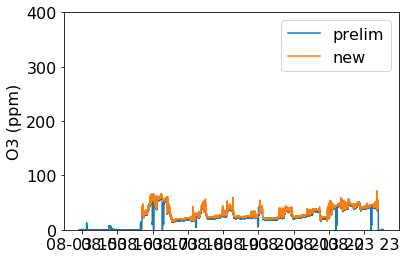

In [9]:
    
    plt.plot(prelim_time, prelim_data, label='prelim')

    plt.plot(time, data, label='new')
    plt.ylim(0,400)
    plt.legend()
    plt.ylabel("{} (ppm)".format(dtype))

In [13]:
fp = CSET_Flight(flight.upper())

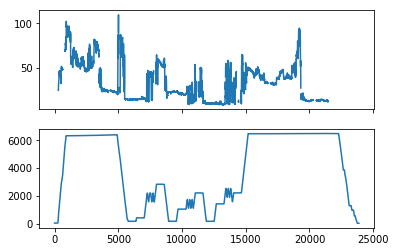

In [18]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True)
ax1.plot(fp.flight_data.O3)
ax2.plot(fp.flight_data.GGALT)

In [8]:
# adding GGLAT, GGLON, GGALT, PSXC from flight_data to chemistry
CO_files = sorted(glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/chemistry/cset-CO*.nc'))
for CO_file in CO_files:
    O3_file = CO_file.replace('cset-CO', 'cset-O3')
    assert os.path.exists(O3_file)
    flight = CO_file[-7:-3]
    flight_file = glob.glob(os.path.join(utils.CSET_flight_dir, flight+'*.nc'))[0]

    vars_to_copy = ['PSXC', 'GGLAT', 'GGLON', 'GGALT']
    with xr.open_dataset(flight_file) as flight_data:
#         print(flight_data)
        flight_time = flight_data['Time']
        flight_vars_dict = {name: flight_data[name] for name in vars_to_copy}
      
    with xr.open_dataset(CO_file) as CO_data, xr.open_dataset(O3_file) as O3_data:
        new_data = CO_data.copy()
        
        #copy differing attrs
        for k, v in O3_data.attrs.items():
            if not CO_data.attrs[k] == v:
                new_data.attrs[k+'_CO'] = CO_data.attrs[k]
                new_data.attrs[k+'_O3'] = v
                del new_data.attrs[k]
        new_data.attrs['history'] = ".ict files for CO and O3 provided by Teresa Campos, converted to netcdf and merged by Johannes Mohrmann. PSXC, GGLAT, GGLON, GGALT added from CSET standard flight data"        
        
                
        #copying O3 data
        for k, v in O3_data.data_vars.items():
            if k not in new_data.data_vars.keys():
                new_data[k] = v
            
        #renaming coordinates
        new_data.rename({"POINTS": "Time"}, inplace=True)
        start_date = dt.datetime.strptime(CO_file[-16:-8], "%Y%m%d")
        new_data = new_data.assign_coords(Time=np.array([start_date + dt.timedelta(seconds=i) for i in new_data['Start_UTC'].values]).astype('datetime64[ns]'))

        
        new_time = new_data['Time']
        new_time.attrs = flight_time.attrs
        new_data['Time'] = new_time
        #some matching:
        t_i = [True if i in flight_time.values else False for i in new_time.values]
        for name, var in flight_vars_dict.items():
            new_arr = np.full(new_time.values.shape, np.nan)
            new_arr[t_i] = var.values
            new_var = xr.DataArray(data=new_arr, dims=('Time',), coords={'Time': new_time}, name=name, attrs = var.attrs)
            new_data[name] = new_var
        
        save_file =  CO_file.replace('cset-CO', 'cset_merged_chem')
#     print(CO_file)
#     print(O3_file)
#     print(flight_file)
#     print(save_file)
        new_data.to_netcdf(path=save_file)

            

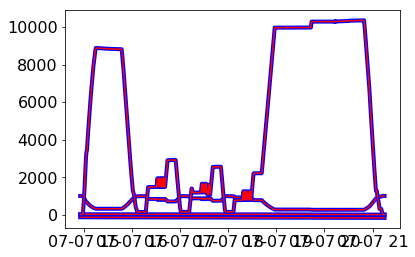

In [205]:
for var in vars_to_copy:
    plt.figure()
    plt.plot(new_data.Time, new_data[var], 'b', lw=4)
    plt.plot(flight_data.Time, flight_data[var], 'r')